In [29]:
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes, binary_dilation
from skimage.transform import rotate
from math import atan2, degrees
import os
from copy import deepcopy
import cv2
from time import time
from matplotlib import pyplot as plt
from skimage.measure import regionprops

In [30]:
imname = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\2022-06-07 14.27.44.tif"

In [31]:
# Define minimum sizes of tissue objects at 1um resolution
minTA = 20000
minTAhole = 100
minDermhole = 5000
minepisize=1000
whitespace=12 #define background pixel value

In [32]:
# Define I/O location
src = os.path.dirname(imname)
dst = os.path.join(src, 'crop_TA')

In [33]:
dst

'\\\\fatherserverdw\\kyuex\\clue images\\1um\\classification_v9_combined\\crop_TA'

In [ ]:

if not os.path.exists(dst): os.mkdir(dst)
fn, ext = os.path.splitext(os.path.basename(imname))
if os.path.exists(os.path.join(dst, '{}_sec{:02d}.png'.format(fn, 1))):
    print('continue')

In [5]:
# open image
im = Image.open(imname)
TAbig = np.array(im)
#TO-DO apply ROI annotation

In [7]:
# downsize to expedite
(width, height) = (im.width // 10, im.height // 10) #downsize by 10
im_resized = im.resize((width, height), resample=0) #nearest interpolation to rescale


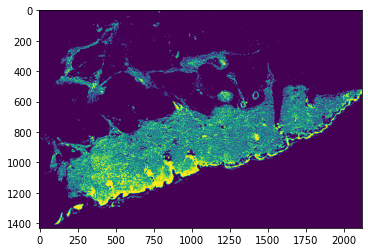

In [8]:
TA = np.array(im_resized) # convert DL mask to numpy array
# separate touching tissue sections using WATERSHED segmentation
sure_foreground = (2 < TA) & (TA < whitespace - 1) #define tissue section conservatively by removing corneum==1, and removing fat==12, so this foreground does not touch adjacent tissue section for sure.
plt.imshow(sure_foreground)

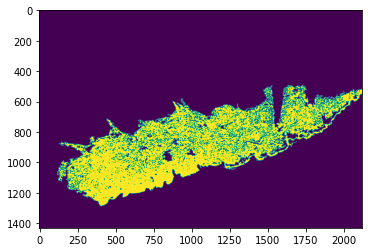

In [9]:
# morphological closing of foreground : dilation followed by an erosion, make larger and smaller to close gaps in the image
sure_fg = closing(sure_foreground, square(3))  # 13sec
# remove small objects not connected to the tissue section
sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
plt.imshow(sure_fg)

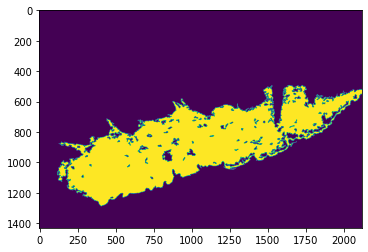

In [10]:
# fill holes in the tissue section
sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)  # 7sec
plt.imshow(sure_fg)

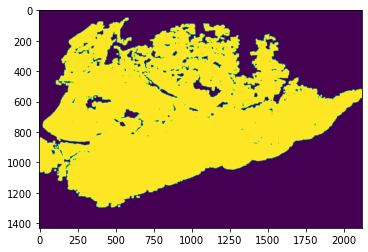

In [11]:
# define background (lenient way to define tissue section)
bw = closing(TA < whitespace, square(3))  # 12 is background
bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
bw = remove_small_holes(bw, area_threshold=minTAhole)
# morphological opening : erosion followed by an dilation to remove small objects
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
# dilate to be more lenient in defining tissue section area
sure_bg = cv2.dilate(opening, kernel, iterations=3)
plt.imshow(sure_bg)

C:\Users\kyuha\AppData\Local\Temp\ipykernel_18784\21952989.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)


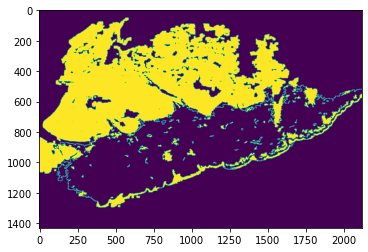

In [12]:
# define middleground
unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)
plt.imshow(unknown)

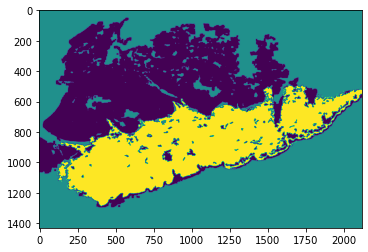

In [13]:
# label that background is 1 and objects are 2~N and middleground is zero
sure_fg_label = label(sure_fg).astype(np.int32)
sure_fg_label = sure_fg_label + 1 #objects are 2~N
sure_fg_label[unknown] = 0 #middle ground is 0
plt.imshow(sure_fg_label)

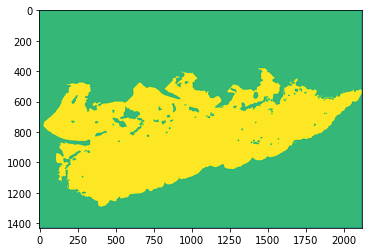

In [14]:
# perform watershed based on the marker
TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR) #convert downsized DL mask to BGR color channel
label_image = cv2.watershed(TAbgr, sure_fg_label) #apply watershed using fg,bg,mg, defined mask
plt.imshow(label_image)

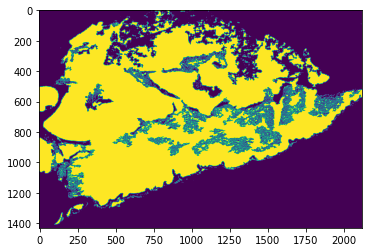

In [15]:
# iterate each section
epi = (TA == 1) | (TA == 2)
derm = (2 < TA) & (TA < whitespace)
derm = remove_small_holes(derm, area_threshold=minDermhole)
plt.imshow(derm)

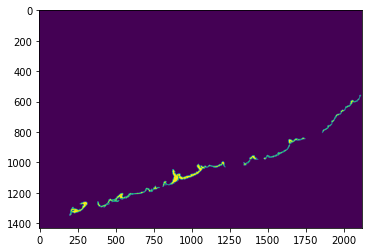

In [16]:
epi2 = epi & ~derm
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)
plt.imshow(epi2)

In [17]:
numsecmax = np.max(label_image)
numsec = 1
print('section N: ', numsec, '/', numsecmax-1)
msktmp = label_image == numsec+1

section N:  1 / 1


In [18]:
stats = regionprops(msktmp.astype(np.uint8))
centroid = stats[0].centroid #NOTE:this returns (y,x)!!
cent = (10*centroid[1],10*centroid[0]) #resize back to the origin image size, flip to (x,y)

In [25]:

# mskderm = msktmp & derm
mskepi = msktmp & epi2
# align point clouds horizontally
[xt2, yt2] = np.where(mskepi) #convert binary mask to point clouds
vertices = np.array([xt2[::10], yt2[::10]]).T #downsample point clouds
vc = vertices - vertices.mean(axis=0) #normalize coordinates to zero / bring object around zero
# use normalized point clouds to calculate degrees to rotate
U, S, Vt = np.linalg.svd(vc)
k = Vt.T
d0 = -degrees(atan2(k[0, 1], k[0, 0])) #convert radian to degree
degrot = np.abs(d0 - 90) # TO-DO: confirm if this is true.
degrot

160.13405241630812

In [26]:
#degrot = d0
degrot

160.13405241630812

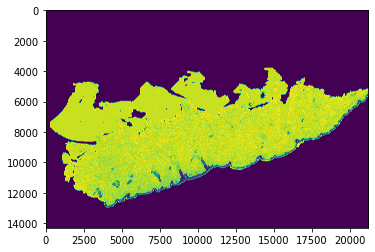

In [27]:
#scale back up to perform rotation
TAtmp = deepcopy(TAbig)
mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
# delete non-ROI from scaled up ROI
kernel = np.ones((20, 20), np.uint8)
mskbig = cv2.dilate(mskbig, kernel, iterations=3)
TAtmp[mskbig == 0] = 0  #1sec
plt.imshow(TAtmp)

In [28]:
# rotate original DL mask using the angle of rotation
start = time() # 10sec
mskrot = rotate(TAtmp, degrot, resize=True, preserve_range=True, order=0)  # this is slow
#can I expedite by not preserving range and recovering original pixel later?
print(round(time() - start), 'sec elapsed for part A')
plt.imshow(mskrot)


KeyboardInterrupt



In [ ]:
start = time()
[xt, yt] = np.where(mskrot) #tissue mask to point clouds
mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)] #find min and max to define boundary
print(round(time() - start), 'sec elapsed for part B')
start = time()
plt.imshow(mskrot2)

17 sec elapsed for part C
0 sec elapsed for part D


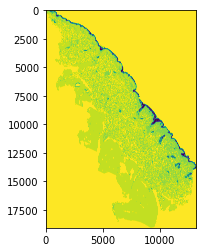

In [24]:
# if dermis is above epidermis, flip it
[xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2))
if np.mean(xt) - np.mean(xt2) < 0:
    mskrot2 = np.rot90(np.rot90(mskrot2))
print(round(time() - start), 'sec elapsed for part C')
start = time()  #
mskrot2[mskrot2 == 0] = whitespace  # assign whitespace value to background
print(round(time() - start), 'sec elapsed for part D')
plt.imshow(mskrot2)

In [54]:
Image.fromarray(mskrot2.astype('int8')).save(
        os.path.join(dst,'{}_sec{:02d}_d0{:d}.png'.format(fn, numsec,round(degrot))))

In [60]:
'{}_sec{:02d}_deg{:d}.png'.format(fn, numsec,round(degrot))

'2022-06-07 14.27.44_sec01_deg-70.png'

In [ ]:
for numsec in range(1,numsecmax):
    print('section N: ', numsec, '/', numsecmax-1)
    msktmp = label_image == numsec+1
    # mskderm = msktmp & derm
    mskepi = msktmp & epi2
    # align point clouds horizontally
    [xt2, yt2] = np.where(mskepi) #convert binary mask to point clouds
    vertices = np.array([xt2[::10], yt2[::10]]).T #downsample point clouds
    vc = vertices - vertices.mean(axis=0) #normalize coordinates to zero / bring object around zero
    # use normalized point clouds to calculate degrees to rotate
    U, S, Vt = np.linalg.svd(vc)
    k = Vt.T
    d0 = -degrees(atan2(k[0, 1], k[0, 0])) #convert radian to degree
    degrot = np.abs(d0 - 90) # TO-DO: confirm if this is true.
    #scale back up to perform rotation
    TAtmp = deepcopy(TAbig)
    mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
    # delete non-ROI from scaled up ROI
    kernel = np.ones((20, 20), np.uint8)
    mskbig = cv2.dilate(mskbig, kernel, iterations=3)
    TAtmp[mskbig == 0] = 0  #1sec
    # rotate original DL mask using the angle of rotation
    start = time() # 10sec
    mskrot = rotate(TAtmp, degrot, resize=True, preserve_range=True, order=0)  # this is slow
    #can I expedite by not preserving range and recovering original pixel later?
    print(round(time() - start), 'sec elapsed for part A')
    # cropping the rotated DL mask
    start = time()
    [xt, yt] = np.where(mskrot) #tissue mask to point clouds
    mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)] #find min and max to define boundary
    print(round(time() - start), 'sec elapsed for part B')
    start = time()

    # if dermis is above epidermis, flip it
    [xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2))
    if np.mean(xt) - np.mean(xt2) < 0:
        mskrot2 = np.rot90(np.rot90(mskrot2))
    print(round(time() - start), 'sec elapsed for part C')
    start = time()  #
    mskrot2[mskrot2 == 0] = whitespace  # assign whitespace value to background
    print(round(time() - start), 'sec elapsed for part D')

    Image.fromarray(mskrot2.astype('int8')).save(
        os.path.join(dst, '{}_sec{:02d}.png'.format(fn, numsec)))